# IMPORTS

In [92]:
import cv2
import numpy as np
import os

from matplotlib import pyplot as plt
import skimage.io as io
from skimage import transform


# SEGMENTATION FUNCTIONS

### STAFF SEGMENTATION

In [96]:
def segment_staff(img):
    # Takes a Uint8 grey image and returns an array of images of staffs
    
    # --- [Standardization Parameters] ---
    # Define the target height for the output staffs.
    # The target width will be the width of the input image.
    TARGET_HEIGHT = 100 
    TARGET_WIDTH = int(img.shape[1] * 0.65)
    # ------------------------------------
    
    inverted_img = (255 - img) / 255 # Converts Uint8 (0-255) to float (0.0-1.0)
    
    # Dilate the image
    struct_element = cv.getStructuringElement(cv.MORPH_RECT,(240,16)) 
    dilated_img = cv.dilate(inverted_img,struct_element,iterations=5)

    # Calculate the Horizontal histogram
    hist_hor = np.sum(dilated_img,axis=1)

    # Calculate the threshold of Segmentation
    sorted_hist_hor = sorted(hist_hor)
    percentage_taken = 0.03
    iteration_values = []
    
    for iteration in range(1,31) :
        # Calculate the Threshold with a different ratio everytime
        current_max_len = int( len(sorted_hist_hor) * percentage_taken * iteration)
        averaged_partition = sorted_hist_hor[0:current_max_len] 
        # Safely calculate average, handle empty partition (shouldn't happen here, but good practice)
        if len(averaged_partition) > 0:
            threshold = round(np.average(averaged_partition))
        else:
            threshold = 0 

        # Calculate the width of the segments using the current threshold
        start_cut = 0
        staff_width = []
        less_flag = 0
        for i in range(len(hist_hor)):
            if less_flag == 0 and hist_hor[i] < threshold:
                less_flag = 1
            elif less_flag == 1 and hist_hor[i] > threshold:
                start_cut = i
                less_flag = 2
            elif less_flag == 2 and hist_hor[i] < threshold:
                staff_width.append( i-start_cut )
                less_flag = 0

        # If there was atleast one segment, we calculate stats
        if len(staff_width) > 0:
            sigma = np.std(staff_width)
            average_width = np.average(staff_width)
            iteration_values.append( (sigma,average_width,len(staff_width),threshold) )

    # ... (Criteria and best threshold selection logic remains the same) ...
    all_sigmas = [itr[0] for itr in iteration_values]
    # Handle case where all_sigmas is empty
    min_sigma = 3 
    if len(all_sigmas) > 0:
        min_sigma = 3 if np.median(all_sigmas) <= 3 else np.median(all_sigmas)

    # Initial value and base case if no segments found
    best_iteration = (0,0,0,0)
    max_segments = 0

    # Comparing to find the best threshold
    for iteration in iteration_values:
        if iteration[0] < min_sigma and iteration[2] > max_segments:
            max_segments = iteration[2]
            best_iteration = iteration
        elif iteration[0] < min_sigma and iteration[1] > best_iteration[1]:
            best_iteration = iteration

    # Find the boundaries with best threshold
    threshold = best_iteration[3]

    start_cut = 0
    staff_indices = []
    less_flag = 0
    for i in range(len(hist_hor)):
        if less_flag == 0 and hist_hor[i] < threshold:
            less_flag = 1
        elif less_flag == 1 and hist_hor[i] > threshold:
            start_cut = i
            less_flag = 2
        elif less_flag == 2 and hist_hor[i] < threshold:
            staff_indices.append( (start_cut,i) )
            less_flag = 0

    # Segment and Resize the Optimal Images
    segmented_staffs = []
    for start_row, end_row in staff_indices:
        # 1. Extract the staff segment
        staff_segment = img[start_row:end_row, :]
        
        # 2. RESIZE THE STAFF SEGMENT
        # Target size is (Original Width, Target Height)
        resized_staff = cv.resize(
            staff_segment, 
            (TARGET_WIDTH, TARGET_HEIGHT), 
            interpolation=cv.INTER_AREA
        )
        
        # 3. Add to the list
        segmented_staffs.append(resized_staff)

    return segmented_staffs

### NOTE SEGMENTATION

In [130]:
# this helps plot stuff. ignore it
def show_images(images, titles=None):
    """Displays multiple images using Matplotlib."""
    if titles is None:
        titles = [f"Image {i+1}" for i in range(len(images))]
        
    images_number = len(images)
    figure = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles), 1):
        a = figure.add_subplot(1, images_number, n)
        
        if image.ndim == 2:
            plt.gray()
            
        plt.imshow(image) 

        a.axis('off') 

    plt.show()

def staff_splicer(original_img):
###############################################################################
# THIS SECTION IS WHAT "SEGMENTS" THE IMAGE
    original_img = original_img > 0.95 # Convert 0-1 float to boolean (True=White, False=Black/Note)
    
    # 1. Identify "empty" columns
    remove = original_img.shape[0] - original_img.sum(axis=0) # Counts number of "black" pixels (notes) per column

    DYNAMIC_THRESHOLD = original_img.shape[0] * 0.12 # Columns with fewer than this many notes are considered "empty"

    # Boolean array: True where column has content (remove >= DYNAMIC_THRESHOLD), False where it's "empty"
    content_columns = (remove >= DYNAMIC_THRESHOLD) 

    # 2. Apply horizontal padding/dilation to the "content" mask
    # This step 'grows' the content mask horizontally to include adjacent empty columns.
    
    # Define a small padding amount (e.g., 5-10 pixels on each side of content)
    HORIZONTAL_PADDING = 6 
    
    # Use convolution or a rolling max to achieve dilation/padding on the 1D array
    padded_content_columns = np.zeros_like(content_columns, dtype=bool)
    
    # Iterate through the content columns and set a small region around them to True
    for i in np.where(content_columns)[0]:
        start = max(0, i - HORIZONTAL_PADDING)
        end = min(len(content_columns), i + HORIZONTAL_PADDING + 1)
        padded_content_columns[start:end] = True
    
    # 3. Create the final segmented image
    segmented_image = np.copy(original_img)

    # Set columns that are NOT in the padded_content_columns mask to white (1)
    segmented_image[:, ~padded_content_columns] = 1 # The '~' is logical NOT for the boolean array

    show_images([original_img, segmented_image], ["Original Image", "Segmented Image with Padding"])
################################################################################

    # now we have to extract the segments from the segmented image, i am doing this using contour segmentation
    thresh = (segmented_image * 255).astype(np.uint8)
    inverted_thresh = cv2.bitwise_not(thresh)

    contours, _ = cv2.findContours(inverted_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 1. Calculate bounding boxes and sort contours by x-coordinate
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    (contours, bounding_boxes) = zip(*sorted(zip(contours, bounding_boxes), key=lambda b: b[1][0]))

    print(f"Found {len(contours)} potential large external objects.")

    segmented_images = []

    # padding stuff. not super important for you to know
    PADDING_FACTOR = 1.00 

    full_height, full_width = thresh.shape[:2] 

    # these are hard coded and ngl i hate that they are but idk how to fix it
    MIN_AREA = 80
    MIN_ASPECT_RATIO = 0.5 
    MAX_AREA = 2000
    MAX_ASPECT_RATIO = 25

    for i, contour in enumerate(contours): # Note: contours is now sorted by x-coordinate
        # We can reuse the bounding box we already calculated and sorted
        x, y, w, h = bounding_boxes[i] 
        
        area = w * h
        aspect_ratio = w / h

        if (area < MIN_AREA or 
        area > MAX_AREA or
        aspect_ratio < MIN_ASPECT_RATIO or
        aspect_ratio > MAX_ASPECT_RATIO): 
            continue
        
        pad_x = 0
        pad_y = int(h * PADDING_FACTOR)
        
        x_start = max(0, x - pad_x)
        y_start = max(0, y - pad_y)
        x_end = min(full_width, x + w + pad_x)
        y_end = min(full_height, y + h + pad_y)
        
        cropped_img = thresh[y_start:y_end, x_start:x_end] 
        segmented_images.append(cropped_img)
        
    # now show all the segments
    show_images(segmented_images)

    return segmented_images

# MAIN SCRIPT FOR SEGMENTATION

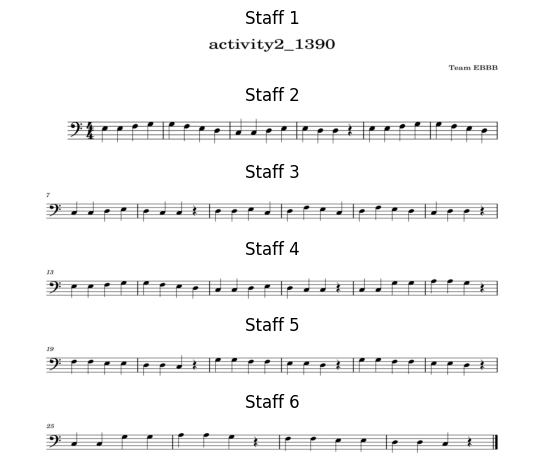

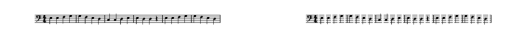

Found 49 potential large external objects.


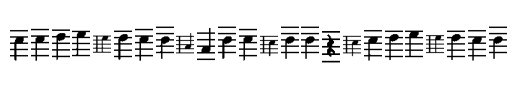

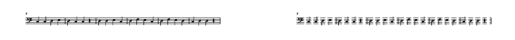

Found 54 potential large external objects.


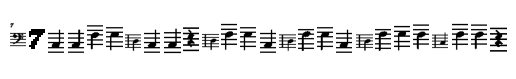

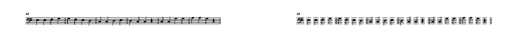

Found 48 potential large external objects.


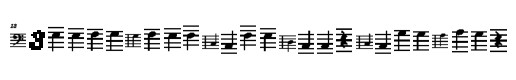

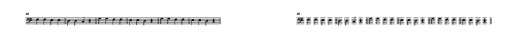

Found 52 potential large external objects.


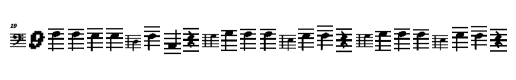

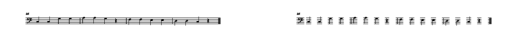

Found 34 potential large external objects.


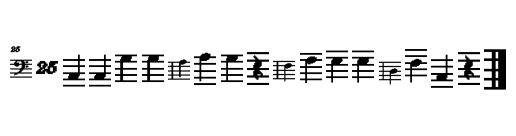

In [141]:
img = io.imread('activity2.png', as_gray=True)

# Define a target height (e.g., 600)
target_height = 600
scale_factor = target_height / img.shape[0]
scaled_img = transform.rescale(img, scale_factor, anti_aliasing=True)

staffs = segment_staff(scaled_img)

staffs = segment_staff(img) # segments the sheet into individual staffs

fig, axes = plt.subplots(len(staffs), 1) 

axes = axes.flatten()
for i, staff in enumerate(staffs):
    axes[i].imshow(staff, cmap='gray') 
    axes[i].set_title(f'Staff {i+1}')
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

for i, staff_img in enumerate(staffs[1:]):
    segments = staff_splicer(staff_img)

    for j, segment in enumerate(segments):
        if i >= 1 and j < 2:
            continue
        
        seg = segment.astype(float)

        # Normalize to [0,1] using the *segment's own* min/max
        seg = (seg - seg.min()) / (seg.max() - seg.min() + 1e-9)

        segment_img = (seg * 255).astype(np.uint8)
        segment_filename = f'TEST_{i+1}_{j+1}.png'
        cv2.imwrite(segment_filename, segment_img)
